In [1]:
import torch
import numpy as np
from vkoga.utilities import OptimizedKernel
from vkoga.tkernels import Matern, Gaussian
import matplotlib.pyplot as plt

In [2]:
# Zur Reproduzierbarkeit der Daten
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Funktionen
def f1(x):
    return 3*x[:, 0] + x[:, 1] # f(x, y) = 3x + y
def f2(x):
    return 0*x[:, 0] + 3*x[:, 1] # f(x, y) = 3y
def f3(x):
    return torch.exp((3*(x[:, 0]-0.5))**2 + (0.1*(x[:, 1]-0.5))**2 + (x[:, 2]-0.5)**2)

In [4]:
def generate_data(size=(10000, 2), function=1):
    X = torch.rand(size) # zufällige Werte zwischen 0 und 1
    if function == 1:
        y = f1(X)
    elif function == 2:
        y = f2(X)
    elif function == 3:
        y = f3(X)
    else:
        y = torch.rand(size[0])
    return X, y

Learned A:
 [[ 0.29  -0.024]
 [ 0.076  0.075]]
Singulärwerte (S): [0.3   0.079]
Linke singuläre Vektoren (U):
 [[-0.968 -0.25 ]
 [-0.25   0.968]]
Rechte singuläre Vektoren (V^T):
 [[-1.     0.015]
 [ 0.015  1.   ]]


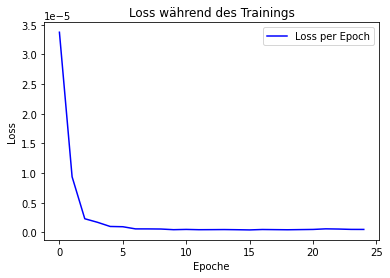

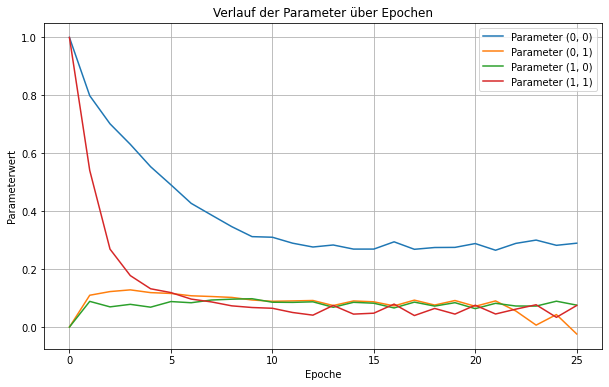

In [5]:
# f1 Daten mit Gaussian Kernel
# Daten generieren mit f1: Transformationsmatrix [[3, 0.0], [0.0, 1]]
X, y = generate_data(size=(10000, 2), function=1)
# Kernmodell initialiesieren
model = OptimizedKernel(kernel=Matern(k=1), dim=X.shape[1], reg_para=1e-5, learning_rate=5e-3, n_epochs=25, 
                                                flag_initialize_diagonal=True,
                                                flag_symmetric_A=False)
# Modell optimieren (training)
model.optimize(X, y, flag_optim_verbose=False)
print("Learned A:\n", model.A.detach().numpy().round(decimals=3))
U, S, VT = np.linalg.svd(model.A.detach().numpy().round(decimals=3))
print("Singulärwerte (S):", S.round(decimals=3))
print("Linke singuläre Vektoren (U):\n", U.round(decimals=3))
print("Rechte singuläre Vektoren (V^T):\n", VT.round(decimals=3))


# Plot des Loss
plt.plot(range(len(model.list_obj)), model.list_obj, label="Loss per Epoch", color='blue')
plt.title("Loss während des Trainings")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot der Einträge von der Matrix A über die Epochen
plt.figure(figsize=(10, 6))
for i in range(2):
    for j in range(2):
        values = [param[i, j].item() for param in model.list_parameters]  # Extrahiere die Werte pro Epoche
        plt.plot(range(len(model.list_parameters)), values, label=f'Parameter ({i}, {j})')
plt.title('Verlauf der Parameter über Epochen')
plt.xlabel('Epoche')
plt.ylabel('Parameterwert')
plt.grid(True)
plt.legend()
plt.show()

Learned A:
 [[ 0.012 -0.001]
 [ 0.058  0.591]]
Singulärwerte (S): [0.594 0.012]
Linke singuläre Vektoren (U):
 [[ 0.  1.]
 [ 1. -0.]]
Rechte singuläre Vektoren (V^T):
 [[ 0.098  0.995]
 [ 0.995 -0.098]]


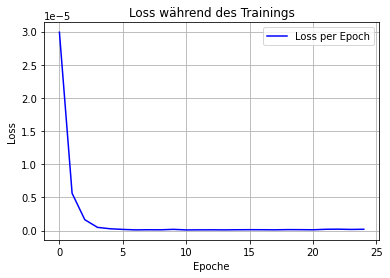

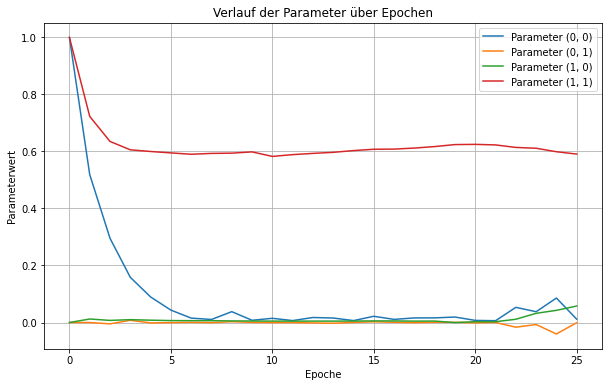

In [6]:
# f2 Daten mit Matern Kernel
# Daten generieren mit f2: Transformationsmatrix [[0.0, 0.0], [0.0, 3]]
X, y = generate_data(size=(10000, 2), function=2)
# Kernmodell initialiesieren
model = OptimizedKernel(kernel=Matern(k=1), dim=X.shape[1], reg_para=1e-5, learning_rate=5e-3, n_epochs=25, 
                                                flag_initialize_diagonal=True,
                                                flag_symmetric_A=False)
# Modell optimieren (training)
model.optimize(X, y, flag_optim_verbose=False)
# Gelernte Matrix untersuchen
print("Learned A:\n", model.A.detach().numpy().round(decimals=3))
U, S, VT = np.linalg.svd(model.A.detach().numpy().round(decimals=3))
print("Singulärwerte (S):", S.round(decimals=3))
print("Linke singuläre Vektoren (U):\n", U.round(decimals=3))
print("Rechte singuläre Vektoren (V^T):\n", VT.round(decimals=3))


# Plot des Loss
plt.plot(range(len(model.list_obj)), model.list_obj, label="Loss per Epoch", color='blue')
plt.title("Loss während des Trainings")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Plot der Einträge von der Matrix A über die Epochen
plt.figure(figsize=(10, 6))
for i in range(2):
    for j in range(2):
        values = [param[i, j].item() for param in model.list_parameters]  # Extrahiere die Werte pro Epoche
        plt.plot(range(len(model.list_parameters)), values, label=f'Parameter ({i}, {j})')
plt.title('Verlauf der Parameter über Epochen')
plt.xlabel('Epoche')
plt.ylabel('Parameterwert')
plt.grid(True)
plt.legend()
plt.show()

Learned A:
 [[ 0.586 -0.133 -0.208]
 [ 0.004 -0.002  0.013]
 [ 0.03   0.11   0.015]]
Singulärwerte (S): [0.636 0.115 0.014]
Linke singuläre Vektoren (U):
 [[-1.    -0.    -0.   ]
 [ 0.    -0.007 -1.   ]
 [ 0.    -1.     0.007]]
Rechte singuläre Vektoren (V^T):
 [[-0.922  0.209  0.327]
 [-0.263 -0.956 -0.13 ]
 [-0.285  0.206 -0.936]]


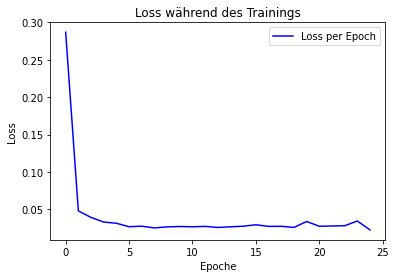

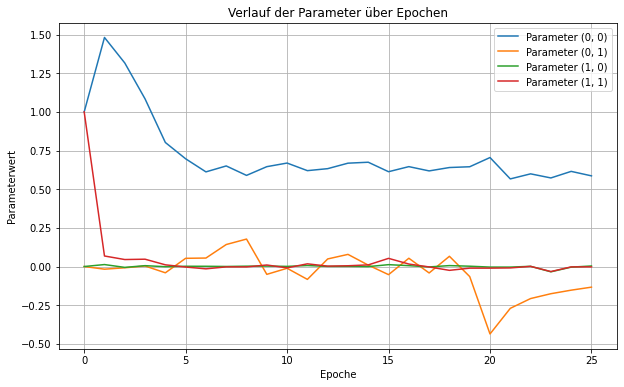

In [7]:
# f3 Daten mit Matern Kernel
# Daten generieren mit f1: Transformationsmatrix [[3, 0.0], [0.0, 1]]
X, y = generate_data(size=(50000, 3), function=3)
# Kernmodell initialiesieren
model = OptimizedKernel(kernel=Matern(k=1), dim=X.shape[1], reg_para=1e-5, learning_rate=5e-3, n_epochs=25, 
                                                flag_initialize_diagonal=True,
                                                flag_symmetric_A=False)
# Modell optimieren (training)
model.optimize(X, y, flag_optim_verbose=False)
print("Learned A:\n", model.A.detach().numpy().round(decimals=3))
U, S, VT = np.linalg.svd(model.A.detach().numpy().round(decimals=3))
print("Singulärwerte (S):", S.round(decimals=3))
print("Linke singuläre Vektoren (U):\n", U.round(decimals=3))
print("Rechte singuläre Vektoren (V^T):\n", VT.round(decimals=3))


# Plot des Loss
plt.plot(range(len(model.list_obj)), model.list_obj, label="Loss per Epoch", color='blue')
plt.title("Loss während des Trainings")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot der Einträge von der Matrix A über die Epochen
plt.figure(figsize=(10, 6))
for i in range(2):
    for j in range(2):
        values = [param[i, j].item() for param in model.list_parameters]  # Extrahiere die Werte pro Epoche
        plt.plot(range(len(model.list_parameters)), values, label=f'Parameter ({i}, {j})')
plt.title('Verlauf der Parameter über Epochen')
plt.xlabel('Epoche')
plt.ylabel('Parameterwert')
plt.grid(True)
plt.legend()
plt.show()